In [1]:
import uproot as ur
import pandas as pd

filename=("/eos/cms/store/group/phys_higgs/moameen/tthmlep/data_forHjTagger_training_2025-05-27/data_forHjTagger.root")
file = ur.open(filename)
print(file.classnames())
tree = file["tree_event"]
dfall = tree.arrays(library="pd")
print ("File loaded with ",dfall.shape[0], " events ")
print ("Df shape before selection :", dfall.shape, "\n")

fulldata = dfall

print ("Df shape after  selection :",fulldata.shape)

{'tree_event;1': 'TTree'}
File loaded with  720822  events 
Df shape before selection : (720822, 17) 

Df shape after  selection : (720822, 17)


In [2]:
target = fulldata["label"].astype(int)
data   = pd.DataFrame(fulldata, columns=["jet25_pt","jet25_lepdrmax","jet25_lepdrmin","jet25_btagDeepFlavB_discScore"])

In [3]:
count_0 = (data["jet25_btagDeepFlavB_discScore"] == 0).sum()
count_1 = (data["jet25_btagDeepFlavB_discScore"] == 1).sum()
count_2 = (data["jet25_btagDeepFlavB_discScore"] == 2).sum()
count_3 = (data["jet25_btagDeepFlavB_discScore"] == 3).sum()
count_4 = (data["jet25_btagDeepFlavB_discScore"] == 4).sum()

print("Count of 0:", count_0)
print("Count of 1:", count_1)
print("Count of 2:", count_2)
print("Count of 3:", count_3)
print("Count of 4:", count_4)

Count of 0: 398847
Count of 1: 94493
Count of 2: 55804
Count of 3: 171678
Count of 4: 0


In [4]:
n_features = data.shape[1]
print(f'No of Features at evaluation = {n_features}')

No of Features at evaluation = 4


In [5]:
# Let's scaled the input features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [6]:
import joblib

modelfile_joblib = "/eos/user/m/moameen/HjTagger/models/model_xgboost_for_HjTagger_27May2025_a_r3"
print(f"Loading to evaluate model: {modelfile_joblib}")
model_joblib = joblib.load(modelfile_joblib)

prob_joblib = model_joblib.predict_proba(data_scaled)[:,1]

Loading to evaluate model: /eos/user/m/moameen/HjTagger/models/model_xgboost_for_HjTagger_27May2025_a_r3


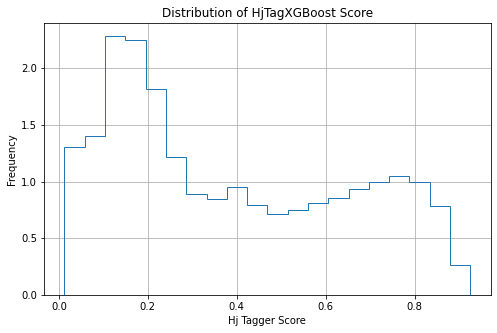

In [7]:
# Now Plots

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(prob_joblib, bins=20, histtype='step', density=True)
plt.title('Distribution of HjTagXGBoost Score')
plt.xlabel('Hj Tagger Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
import onnxruntime as rt

sess = rt.InferenceSession("/eos/user/m/moameen/multilepton-analysis/data/models_hjtagger/model_xgboost_for_HjTagger_27May2025_a_r3.onnx", providers=["CPUExecutionProvider"])
# Check model inputs and outputs
print("Inputs:")
for inp in sess.get_inputs():
    print(f"  {inp.name}, shape: {inp.shape}, type: {inp.type}")

print("Outputs:")
for out in sess.get_outputs():
    print(f"  {out.name}, shape: {out.shape}, type: {out.type}")
    
label = sess.get_outputs()[0].name
probabilities = sess.get_outputs()[1].name

Inputs:
  float_input, shape: [None, 4], type: tensor(float)
Outputs:
  label, shape: [None], type: tensor(int64)
  probabilities, shape: [None, 2], type: tensor(float)


In [9]:
print(data_scaled.dtype)

float64


In [10]:
import numpy as np
data_scaled = data_scaled.astype(np.float32)

In [11]:
# Run prediction
pred_onnx = sess.run([probabilities], {"float_input": data_scaled})[0]
print(pred_onnx)

[[0.78404397 0.21595603]
 [0.79287505 0.20712495]
 [0.68443054 0.31556946]
 ...
 [0.8243513  0.17564869]
 [0.79084    0.20915997]
 [0.5306368  0.4693632 ]]


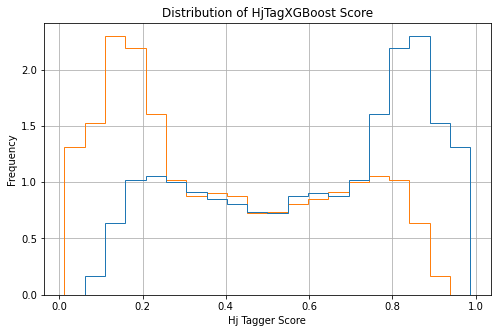

In [12]:
# Now Plots

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(pred_onnx, bins=20, histtype='step', density=True)
plt.title('Distribution of HjTagXGBoost Score')
plt.xlabel('Hj Tagger Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

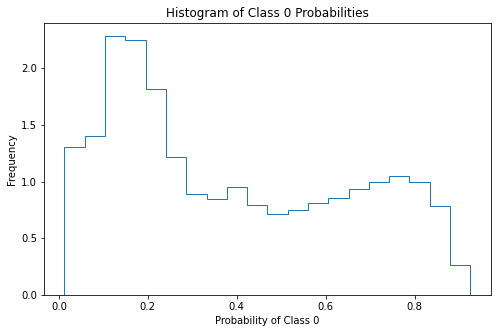

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(pred_onnx[:, 1], bins=20, histtype='step', density=True)
plt.xlabel("Probability of Class 0")
plt.ylabel("Frequency")
plt.title("Histogram of Class 0 Probabilities")
plt.show()

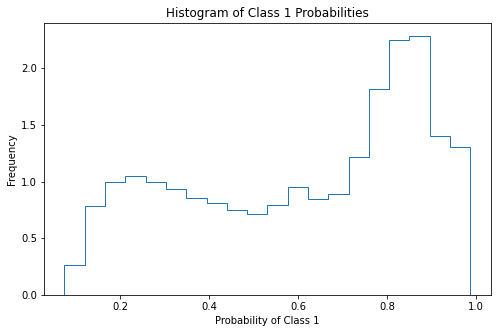

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(pred_onnx[:, 0], bins=20, histtype='step', density=True)
plt.xlabel("Probability of Class 1")
plt.ylabel("Frequency")
plt.title("Histogram of Class 1 Probabilities")
plt.show()